In [1]:
import numpy as np
from scipy.optimize import Bounds, BFGS
from scipy.optimize import LinearConstraint, minimize

In [2]:
class MySVM:
    ZERO = 1e-7

    isTrained = False
    w_opt = -1
    b_opt = -1

    def calculate_lagrange_dual(self, alpha, x, t):
        """
        Lagrangian function L is given below
        L = ∑ αi - 0.5 * (∑ ∑ αi * αk * ti * tk * (xi.xk)

        xi and xk are vectors. All the remaining are scalars.

        Since the dual problem is to maximize L, we return -L because minimizing(-L) is same as maximizing L
        In the optimize function we are using minimize instead of maximize.

        :param alpha:
        :param x: input vector
        :param t: target

        :return: -L
        """
        alpha = alpha.reshape(alpha.shape[0], 1)
        alpha_t = np.multiply(alpha, t)
        alpha_tx = np.multiply(alpha_t.T, x.T)
        result = 0.5 * np.sum(np.dot(alpha_tx.T, alpha_tx)) - np.sum(alpha)
        return result

    def optimize_alpha(self, x, t, C):
        """
        The dual optimization problem is:

        maximize L(w, b, alpha)

        Constraints:
        αi >= 0
        ∑ αi*ti = 0

        :param x: Input vector
        :param t: target
        :param C: User defined regularization penalty

        :return: alpha
        """
        m, n = x.shape
        np.random.seed(1)
        # Initialize alphas to random values
        alpha_0 = np.random.rand(m) * C
        # Define the constraint
        linear_constraint = LinearConstraint(t, [0], [0])
        # Define the bounds
        bounds_alpha = Bounds(np.zeros(m), np.full(m, C))
        t = t.reshape(t.shape[0], 1)
        # Find the optimal value of alpha
        result = minimize(self.calculate_lagrange_dual, alpha_0, args=(x, t), method='trust-constr',
                          hess=BFGS(), constraints=[linear_constraint],
                          bounds=bounds_alpha)
        # The optimized value of alpha lies in result.x
        alpha = result.x
        return alpha

    def calculate_w_optimum(self, alpha, t, x):
        """
        w* = ∑ αi*ti*xi   (using closed form)

        :param t: target
        :param x: input
        :return: w*
        """
        m = len(x)
        # Get all support vectors
        w = np.zeros(x.shape[1])
        for i in range(m):
            w = w + alpha[i] * t[i] * x[i, :]
        return w

    def calculate_b_optimum(self, alpha, t, x, w):
        """
        b* = average(t - (w* . x))

        :param alpha: alpha
        :param t: target
        :param x: input
        :param w: optimum w
        :return: b*
        """
        ind_sv = np.where((alpha > self.ZERO))[0]
        w0 = 0.0
        for s in ind_sv:
            w0 = w0 + t[s] - np.dot(x[s, :], w)
        # Take the average
        w0 = w0 / len(ind_sv)
        return w0

    def reset(self):
        self.isTrained = False

    def train(self, x, t, C):
        """
        Calculate w_optimum and b_optimum for the SVM

        :param x: Input vectors
        :param t: target
        :param C: User defined regularization penalty
        :return:
        """
        self.isTrained = False
        alpha = self.optimize_alpha(x, t, C)
        self.w_opt = self.calculate_w_optimum(alpha, t, x)
        self.b_opt = self.calculate_b_optimum(alpha, t, x, self.w_opt)
        self.isTrained = True

    def classify(self, x_test):
        """
        calculate : (w.x) + b -> if +ve : target class = 1 otherwise -1

        :param x_test: Test points
        :return: predicted class of the test points
        """

        predicted_labels = np.sum(x_test * self.w_opt, axis=1) + self.b_opt
        predicted_labels = np.sign(predicted_labels)
        # Assign a label arbitrarily a +1 if it is zero
        predicted_labels[predicted_labels == 0] = 1
        #predicted_labels[predicted_labels == -1] = 0
        return predicted_labels

    def accuracy(self, labels, predictions):
        N = len(labels)
        return (labels == predictions).sum() / N * 100

In [3]:
# data processing
import pandas as pd 

# data visualization
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style

from sklearn.svm import SVC, LinearSVC

In [4]:
test_df = pd.read_csv("titanic_test.csv")
train_df = pd.read_csv("titanic_train.csv")

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  348 non-null    int64  
 1   Survived     348 non-null    int64  
 2   Pclass       348 non-null    int64  
 3   Name         348 non-null    object 
 4   Sex          348 non-null    object 
 5   Age          280 non-null    float64
 6   SibSp        348 non-null    int64  
 7   Parch        348 non-null    int64  
 8   Ticket       348 non-null    object 
 9   Fare         348 non-null    float64
 10  Cabin        82 non-null     object 
 11  Embarked     347 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 32.8+ KB


In [6]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,348.000000,348.000000,348.000000,280.00000,348.000000,348.000000,348.000000
mean,177.198276,0.393678,2.324713,28.85625,0.623563,0.387931,33.066186
std,108.062893,0.489268,0.828713,14.48980,1.265465,0.779103,50.395762
min,1.000000,0.000000,1.000000,0.83000,0.000000,0.000000,0.000000
25%,87.750000,0.000000,2.000000,19.75000,0.000000,0.000000,8.044800
50%,176.500000,0.000000,3.000000,28.00000,0.000000,0.000000,14.772900
75%,263.250000,1.000000,3.000000,37.00000,1.000000,0.250000,31.068750
max,891.000000,1.000000,3.000000,71.00000,8.000000,5.000000,512.329200


In [7]:
train_df.head(8)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S


In [8]:
total = train_df.isnull().sum().sort_values(ascending=False)
percent_1 = train_df.isnull().sum()/train_df.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(5)

,Total,%
Cabin,266,76.4
Age,68,19.5
Embarked,1,0.3
PassengerId,0,0.0
Survived,0,0.0


In [9]:
train_df.columns.values

array(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], dtype=object)

/Users/debrajray/PycharmProjects/566SVM/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


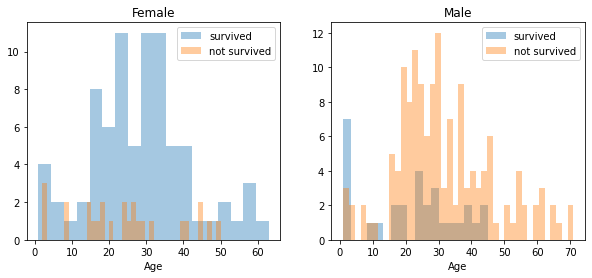

In [10]:
survived = 'survived'
not_survived = 'not survived'
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))
women = train_df[train_df['Sex']=='female']
men = train_df[train_df['Sex']=='male']
ax = sns.distplot(women[women['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[0], kde =False)
ax = sns.distplot(women[women['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[0], kde =False)
ax.legend()
ax.set_title('Female')
ax = sns.distplot(men[men['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[1], kde = False)
ax = sns.distplot(men[men['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[1], kde = False)
ax.legend()
_ = ax.set_title('Male')

In [11]:
data = [train_df, test_df]
for dataset in data:
    dataset['relatives'] = dataset['SibSp'] + dataset['Parch']
    dataset.loc[dataset['relatives'] > 0, 'not_alone'] = 0
    dataset.loc[dataset['relatives'] == 0, 'not_alone'] = 1
    dataset['not_alone'] = dataset['not_alone'].astype(int)
train_df['not_alone'].value_counts()

1    199
0    149
Name: not_alone, dtype: int64

/Users/debrajray/PycharmProjects/566SVM/venv/lib/python3.8/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/debrajray/PycharmProjects/566SVM/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


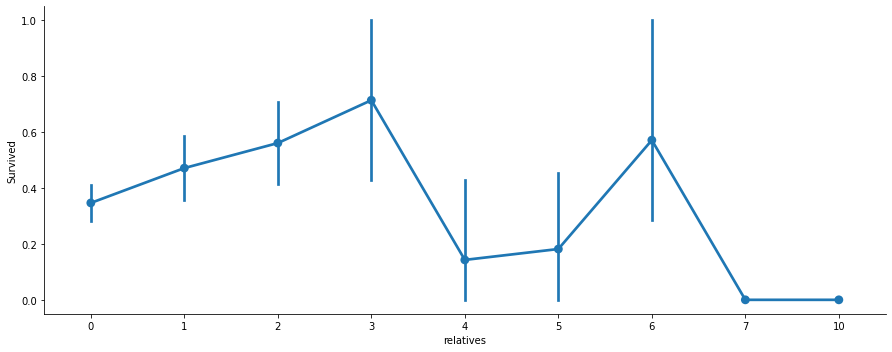

In [12]:
axes = sns.factorplot('relatives','Survived', 
                      data=train_df, aspect = 2.5, )

In [13]:
train_df = train_df.drop(['PassengerId'], axis=1)
test_df = test_df.drop(['PassengerId'], axis=1)

In [14]:
import re
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
data = [train_df, test_df]

for dataset in data:
    dataset['Cabin'] = dataset['Cabin'].fillna("U0")
    dataset['Deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna(0)
    dataset['Deck'] = dataset['Deck'].astype(int)
# we can now drop the cabin feature
train_df = train_df.drop(['Cabin'], axis=1)
test_df = test_df.drop(['Cabin'], axis=1)

In [15]:
data = [train_df, test_df]

for dataset in data:
    mean = train_df["Age"].mean()
    std = test_df["Age"].std()
    is_null = dataset["Age"].isnull().sum()
    # compute random numbers between the mean, std and is_null
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    # fill NaN values in Age column with random values generated
    age_slice = dataset["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset["Age"] = age_slice
    dataset["Age"] = train_df["Age"].astype(int)
train_df["Age"].isnull().sum()

0

In [16]:
train_df['Embarked'].describe()

count     347
unique      3
top         S
freq      248
Name: Embarked, dtype: object

In [17]:
common_value = 'S'
data = [train_df, test_df]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].fillna(common_value)


In [18]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Survived   348 non-null    int64  
 1   Pclass     348 non-null    int64  
 2   Name       348 non-null    object 
 3   Sex        348 non-null    object 
 4   Age        348 non-null    int64  
 5   SibSp      348 non-null    int64  
 6   Parch      348 non-null    int64  
 7   Ticket     348 non-null    object 
 8   Fare       348 non-null    float64
 9   Embarked   348 non-null    object 
 10  relatives  348 non-null    int64  
 11  not_alone  348 non-null    int64  
 12  Deck       348 non-null    int64  
dtypes: float64(1), int64(8), object(4)
memory usage: 35.5+ KB


In [19]:
data = [train_df, test_df]

for dataset in data:
    dataset['Fare'] = dataset['Fare'].fillna(0)
    dataset['Fare'] = dataset['Fare'].astype(int)

In [20]:
data = [train_df, test_df]
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

for dataset in data:
    # extract titles
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    # replace titles with a more common title or as Rare
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                            'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    # convert titles into numbers
    dataset['Title'] = dataset['Title'].map(titles)
    # filling NaN with 0, to get safe
    dataset['Title'] = dataset['Title'].fillna(0)
train_df = train_df.drop(['Name'], axis=1)
test_df = test_df.drop(['Name'], axis=1)

In [21]:
genders = {"male": 0, "female": 1}
data = [train_df, test_df]

for dataset in data:
    dataset['Sex'] = dataset['Sex'].map(genders)

In [22]:
train_df['Ticket'].describe()

count        348
unique       302
top       347077
freq           4
Name: Ticket, dtype: object

In [23]:
train_df = train_df.drop(['Ticket'], axis=1)
test_df = test_df.drop(['Ticket'], axis=1)

In [24]:
ports = {"S": 0, "C": 1, "Q": 2}
data = [train_df, test_df]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].map(ports)

In [25]:
train_df = train_df.drop(columns=['Age'])
test_df = test_df.drop(columns=['Age'])

In [26]:
train_df.head(10)

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked,relatives,not_alone,Deck,Title
0,0,3,0,1,0,7,0,1,0,8,1
1,1,1,1,1,0,71,1,1,0,3,3
2,1,3,1,0,0,7,0,0,1,8,2
3,1,1,1,1,0,53,0,1,0,3,3
4,0,3,0,0,0,8,0,0,1,8,1
5,0,3,0,0,0,8,2,0,1,8,1
6,0,1,0,0,0,51,0,0,1,5,1
7,0,3,0,3,1,21,0,4,0,8,4
8,1,3,1,0,2,11,0,2,0,8,3
9,1,2,1,1,0,30,1,1,0,8,3


In [27]:
data = [train_df, test_df]

for dataset in data:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[(dataset['Fare'] > 31) & (dataset['Fare'] <= 99), 'Fare']   = 3
    dataset.loc[(dataset['Fare'] > 99) & (dataset['Fare'] <= 250), 'Fare']   = 4
    dataset.loc[ dataset['Fare'] > 250, 'Fare'] = 5
    dataset['Fare'] = dataset['Fare'].astype(int)

In [28]:
for dataset in data:
    dataset['Fare_Per_Person'] = dataset['Fare']/(dataset['relatives']+1)
    dataset['Fare_Per_Person'] = dataset['Fare_Per_Person'].astype(int)
# Let's take a last look at the training set, before we start training the models.
train_df.head(10)

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked,relatives,not_alone,Deck,Title,Fare_Per_Person
0,0,3,0,1,0,0,0,1,0,8,1,0
1,1,1,1,1,0,3,1,1,0,3,3,1
2,1,3,1,0,0,0,0,0,1,8,2,0
3,1,1,1,1,0,3,0,1,0,3,3,1
4,0,3,0,0,0,1,0,0,1,8,1,1
5,0,3,0,0,0,1,2,0,1,8,1,1
6,0,1,0,0,0,3,0,0,1,5,1,3
7,0,3,0,3,1,2,0,4,0,8,4,0
8,1,3,1,0,2,1,0,2,0,8,3,0
9,1,2,1,1,0,2,1,1,0,8,3,1


In [29]:
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test = test_df.drop("Survived", axis=1)
Y_test = test_df["Survived"]

In [30]:
linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)

Y_pred = linear_svc.predict(X_test)

acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)

/Users/debrajray/PycharmProjects/566SVM/venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [31]:
acc_linear_svc

80.46

In [32]:
type(X_train)

pandas.core.frame.DataFrame

In [33]:
svm = MySVM()
x = X_train.to_numpy()
t = Y_train.to_numpy()
t[ t == 0 ] = -1
svm.train(x, t, 100)
predictions = svm.classify(x)
print(svm.accuracy(predictions, t))

77.01149425287356


In [34]:
X_test = test_df.drop("Survived", axis=1)
Y_test = test_df["Survived"]

In [35]:
x_test = X_test.to_numpy()
t_test = Y_test.to_numpy()
t_test[ t_test == 0 ] = -1
predictions = svm.classify(x_test)
print(svm.accuracy(predictions, t_test))

80.76923076923077
